# Distance and Tangential Velocity Inference

**Author**: Joris De Ridder

## The goal of this notebook

This notebook draws from GAIA-C8-TN-MPIA-CBJ-081. 

Given the parallax $\varpi$ (in mas) of a star, and its proper motion $\mu_{\alpha^*}$ and $\mu_{\delta}$ (in mas/yr):

$$\mathbf{x} = (\varpi, \mu_{\alpha^*}, \mu_{\delta})^t$$
we would like to derive

$$\boldsymbol{\theta} = (d, v_{\perp}, \varphi)^t$$
That is:
  * d: the distance in parsec
  * $v_{\perp}$: the tangential speed in km/s 
  * $\varphi$: the direction of travel, anticlockwise from North
  
Given the true $\mathbf{\theta}$ it's in principle easy to compute a noise-free $\mathbf{x}$, using

$$\mathbf{m} = \left(\frac{10^3}{d}, \frac{10^3}{c_2}\frac{v_{\perp} \sin\varphi}{d}, \frac{10^3}{c_2}\frac{v_{\perp} \cos\varphi}{d}\right)^t$$
where $c_2 = \text{AU km}^{-1} \text{yr}^{-1} = 4.74047$.

The inverse transformation is easy to derive analytically:

$$\widehat{\boldsymbol{\theta}} = \left(\frac{10^3}{\varpi}, c_2 \frac{\sqrt{\mu^2_{\alpha^*} + \mu^2_{\delta}}}{\varpi}, \text{arctan}\left(\frac{\mu_{\alpha^*}}{\mu_{\delta}}\right)\right)^t$$

but behaves badly under noisy conditions. We therefore will use a Monte Carlo approach, where at the same time we take into account all observational uncertainties and correlations. For more information, we refer to GAIA-C8-TN-MPIA-CBJ-081.

## Imports

The warnings filter gets rid of the deprecation and future warnings that sometimes come with imports.

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np

In [3]:
import scipy as sp

In [4]:
import pymc3 as pm

In [5]:
import emcee

In [6]:
import theano as th

In [7]:
from astroquery.gaia import Gaia

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
%matplotlib inline

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
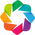

In [9]:
import holoviews as hv
hv.extension('bokeh')

## Get the observed data from the Gaia archive

We will apply the exercise on the following star from the Tycho catalog.

In [10]:
tychoID = "5584-552-1"

In [11]:
query = \
"""
select
    g.source_id, g.parallax, g.parallax_error, 
    g.pmra, g.pmra_error, g.pmdec, g.pmdec_error,
    g.parallax_pmdec_corr, g.parallax_pmra_corr, g.pmra_pmdec_corr
from
    gaiadr2.gaia_source as g,
    gaiadr2.tycho2_best_neighbour as t
where
    t.original_ext_source_id = '{0}'
    AND
    g.source_id = t.source_id
""".format(tychoID)

In [12]:
job = Gaia.launch_job_async(query, dump_to_file=False)

Launched query: '
select
    g.source_id, g.parallax, g.parallax_error, 
    g.pmra, g.pmra_error, g.pmdec, g.pmdec_error,
    g.parallax_pmdec_corr, g.parallax_pmra_corr, g.pmra_pmdec_corr
from
    gaiadr2.gaia_source as g,
    gaiadr2.tycho2_best_neighbour as t
where
    t.original_ext_source_id = '5584-552-1'
    AND
    g.source_id = t.source_id
'
Retrieving async. results...
Query finished.


In [13]:
results = job.get_results()
results

source_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,parallax_pmdec_corr,parallax_pmra_corr,pmra_pmdec_corr
,mas,mas,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32
6319698923254910080,5.87269350139722,0.0714450071571932,-0.31803823168237416,0.12734961041255632,0.03765762332142479,0.1472954138519097,-0.49295583,0.32056078,-0.6319774


Put the information in numpy arrays

The observed value of 
$$\mathbf{x} = (\varpi, \mu_{\alpha^*}, \mu_{\delta})^t$$

In [14]:
observed = np.array([results['parallax'][0], results['pmra'][0], results['pmdec'][0]])
print(observed)

[ 5.8726935  -0.31803823  0.03765762]


The covariance matrix of $\mathbf{x}$:

In [15]:
cov = np.zeros((3,3))
cov[0,0] = results['parallax_error'][0]**2
cov[1,1] = results['pmra_error'][0]**2
cov[2,2] = results['pmdec_error'][0]**2
cov[0,1] = results['parallax_pmra_corr'][0] * results['parallax_error'][0] * results['pmra_error'][0]
cov[1,0] = cov[0,1]
cov[0,2] = results['parallax_pmdec_corr'][0] * results['parallax_error'][0] * results['pmdec_error'][0]
cov[2,0] = cov[0,2]
cov[1,2] = results['pmra_pmdec_corr'][0] * results['pmra_error'][0] * results['pmdec_error'][0]
cov[2,1] = cov[1,2]
print(cov)

[[ 0.00510439  0.00291662 -0.00518763]
 [ 0.00291662  0.01621792 -0.01185464]
 [-0.00518763 -0.01185464  0.02169594]]


## The likelihood and priors

As likelihood for $\bf x$ we use a 3D multivariate Gaussian:

$$P(\mathbf{x} \ | \ \boldsymbol{\theta}) = \frac{1}{(2\pi)^{3/2} \ |V|^{1/2}} \ \exp\left[-\frac{1}{2} (\mathbf{x} - \mathbf{m}(\boldsymbol{\theta})^t \ V^{-1} \ (\mathbf{x} - \mathbf{m}(\boldsymbol{\theta}))\right]$$

where $V$ is the covariance matrix, which we set to the observational one above.

As prior for $\mathbf{x}$ we assume

$$P(\mathbf{x}) = P(d) \ P(v_{\perp}) \ P(\varphi)$$

As prior for the distance we take a $\text{Gamma}(2, 1/L)$ distribution:

$$P(d) = \frac{1}{2L^3} \ d^2 \ e^{-d/L}$$

We're setting an ad hoc prior scale length $L$, but in fact we should choose it according the target's line of sight. See Bailer-Jones et al. (2018)

In [16]:
scaleLength = 500           # pc

This prior can be visualized with:

In [17]:
x = np.linspace(0,5000, 500)
y = sp.stats.gamma.pdf(x, 2, scale=scaleLength)

In [18]:
%%opts Curve [width=650 height=350 show_grid=True fontsize={'xlabel':11, 'ylabel':11, 'ticks':11}] 
hv.Curve(zip(x,y)).redim.label(x='distance (pc)', y='Prior density')

:Curve   [x]   (y)

As prior for the velocity we assume a $\text{Beta}(\alpha=2, \beta=3)$ distribution:

$$P(v) = \frac{1}{B(\alpha,\beta)} \ \left(\frac{v}{v_{\rm max}}\right)^{\alpha-1}\ \left(1-\frac{v}{v_{\rm max}} \right)^{\beta-1}$$

We set the maximum velocity to:

In [19]:
Vmax = 500.0

This prior looks like:

In [20]:
x = np.linspace(0,1,100)
y = sp.stats.beta.pdf(x, a=2, b=3)

In [21]:
%%opts Curve [width=650 height=350 show_grid=True fontsize={'xlabel':11, 'ylabel':11, 'ticks':11}] 
hv.Curve(zip(x*Vmax, y)).redim.label(x='Tangential velocity (km/s)', y='Prior density')

:Curve   [x]   (y)

The prior for the direction of travel is simply a $\text{Uniform}(0,2\pi)$ distribution:

$$ P(\varphi) = \frac{1}{2\pi}$$


## Set up the PyMC3 Monte Carlo model

In [22]:
with pm.Model() as myModel:
    
    # The priors
    
    distance = pm.Gamma('distance', alpha=2, beta=1/scaleLength)
    velocity = pm.Beta('velocity', alpha=2, beta=3)
    angle    = pm.Uniform('angle', lower=0.0, upper=2*np.pi)
    
    # Expected value of x given the distance, the tangential velocity, and the angle
    
    c2 = 4.74047
    mu = [1000/distance, 1000/distance/c2 * Vmax * velocity * np.sin(angle), 1000/distance/c2 * Vmax * velocity * np.cos(angle)]
    
    # The likelihood
    
    x = pm.MvNormal('x', mu=mu, cov=cov, observed=observed)
    
    # Sample the posterios
    
    trace = pm.sample(2500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [angle_interval__, velocity_logodds__, distance_log__]
INFO:pymc3:NUTS: [angle_interval__, velocity_logodds__, distance_log__]
100%|██████████| 3000/3000 [00:08<00:00, 357.68it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '16467' (I am process '16468')
INFO:theano.gof.compilelock:Waiting for existing lock by process '16467' (I am process '16468')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/joris/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /Users/joris/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting fo

## Get the MCMC best estimates from the posterior

In [23]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
distance,170.421809,2.049058,0.030657,166.487372,174.527939,5167.0,0.999976
velocity,0.000578,0.000206,0.000003,0.000213,0.001004,4395.0,1.000570
angle,4.751337,0.470362,0.007939,3.721629,5.491497,4576.0,1.000378


Note that the velocity should be multiplied by Vmax and the angle is expressed in radians.

Find the maximum of the posterior distribution:

In [24]:
start = {'distance':170, 'velocity':0.00057, 'angle':4.73}
maxAPosteriori = pm.find_MAP(start=start, model=myModel)

logp = -10.215, ||grad|| = 0.54702: 100%|██████████| 26/26 [00:00<00:00, 1378.80it/s]  


In [25]:
for quantity, prefactor in zip(['distance', 'velocity', 'angle'], [1, Vmax, 180./np.pi]):
    print(quantity + ": ", prefactor * maxAPosteriori[quantity])

distance:  170.62804572994395
velocity:  0.3047767007073666
angle:  282.62574988021925


## Visualize the MC chains

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23dc99e8>,
      dtype=object)

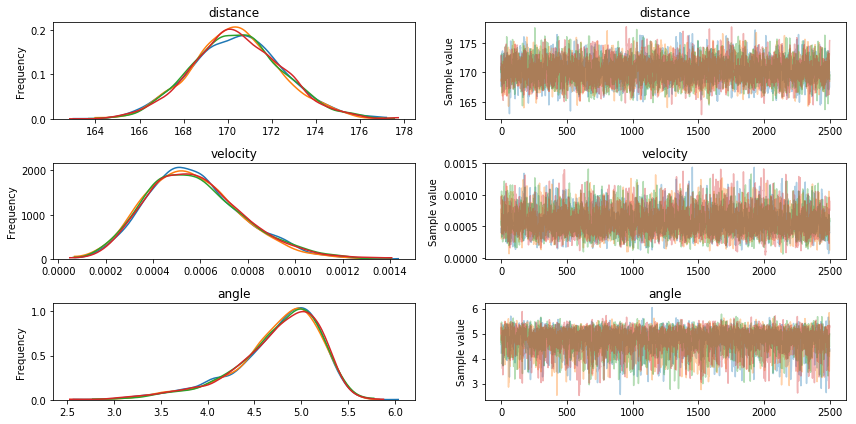

In [244]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10d3f8ba8>,
      dtype=object)

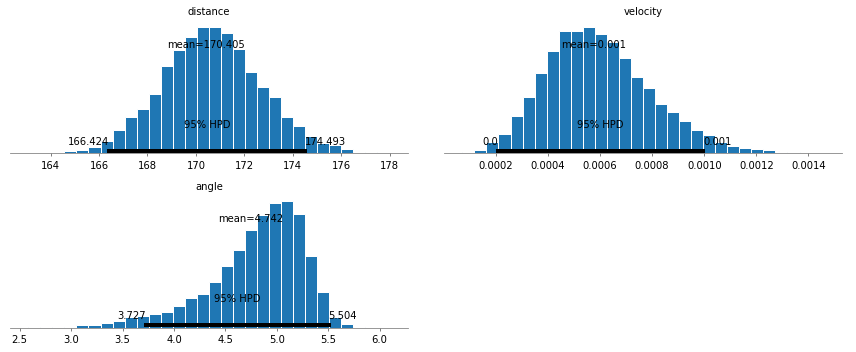

In [245]:
pm.plot_posterior(trace)

In [246]:
tracedf = pm.trace_to_dataframe(trace, varnames=['distance', 'velocity', 'angle'])

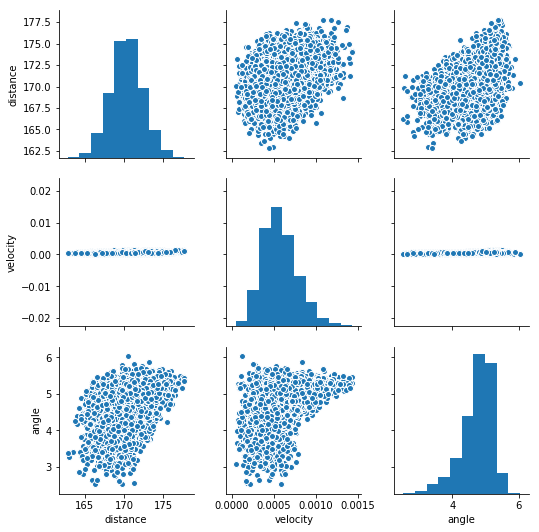

In [247]:
sns.pairplot(tracedf)

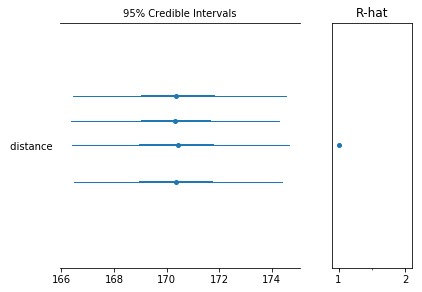

In [248]:
pm.forestplot(trace, varnames=['distance'])

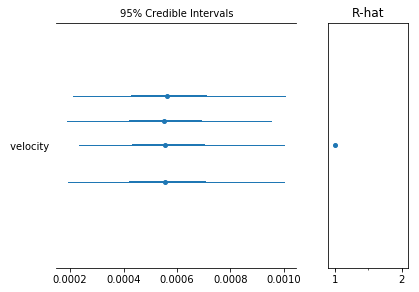

In [249]:
pm.forestplot(trace, varnames=['velocity'])

## Do exactly the same thing with $Emcee$

When sampling the model with PyMC3 I noticed that the NUTS sampler didn't always converge, depending on the star that was selected. In those cases, you need to either reconfigure the PyMC sampler, or try another sampler alltogether. Below I try the $Emcee$ sampler of Foreman-Mackey.  

Define all the log-probabilities. Note: the log-probability distributions need to be given only up to a constant

In [250]:
def logLikelihood(x, dist, vel, angle, invCov, Vmax):
    # Normal distribution
    c2 = 4.74047
    mu = np.array([1000/dist, 1000/dist/c2 * Vmax * vel * np.sin(angle), 1000/dist/c2 * Vmax * vel * np.cos(angle)])
    return -0.5 * np.dot(x-mu, np.dot(invCov, x-mu))

In [251]:
def logPriorDistance(d, L):
    # Gamma distribution
    return 2.0 * np.log(d) - d / L

In [252]:
def logPriorVelocity(v, vmax, alpha, beta):
    # Beta distribution
    return (alpha-1) * np.log(v/vmax) + (beta-1) * np.log(1-v/vmax)

In [253]:
def logPriorAngle(angle):
    # Uniform distribution
    twopi = 2.*np.pi
    if (angle > 0.0) and (angle <= twopi):
        return -np.log(twopi)
    else:
        return -np.inf

In [254]:
def logPosterior(theta, obs, invCov, Vmax, L):
    
    dist  = theta[0]
    vel   = theta[1]
    angle = theta[2]
    
    logPrior1 = logPriorDistance(dist, L)
    if not np.isfinite(logPrior1):
        return -np.inf
    
    logPrior2 = logPriorVelocity(vel, Vmax, 2, 3)
    if not np.isfinite(logPrior2):
        return -np.inf
    
    logPrior3 = logPriorAngle(angle)
    if not np.isfinite(logPrior3):
        return -np.inf
    
    logLike = logLikelihood(obs, dist, vel, angle, invCov, Vmax)
    logPost = logLike + logPrior1 + logPrior2 + logPrior3
    return  logPost

Set up the $Emcee$ sampler. This sampler uses affine invariant Markov chain Monte Carlo Ensemble sampling. 

In [255]:
Ndim = 3
Nwalkers = 4 * Ndim
invCov = np.linalg.inv(cov)
sampler = emcee.EnsembleSampler(Nwalkers, Ndim, logPosterior, args=(observed, invCov, Vmax, scaleLength))

Initialize the starting point for each walker.

In [256]:
pos = [np.array([500., 50., 3.14]) + np.random.normal(size=Ndim) for n in range(Nwalkers)]

Run the sampler

In [257]:
output = sampler.run_mcmc(pos, 5000)

Skip the initial (unstabilized) steps and flatten the chain so that we get a flat list of samples

In [258]:
Nskip = 50
samples = sampler.chain[:, Nskip:, :].reshape((-1, Ndim))

### Compute the median and the 68% interval boundaries

In [259]:
unitFactors = np.array([1, Vmax, 180./np.pi])
percentiles = np.percentile(samples, [16, 50, 84], axis=0) * unitFactors
percentiles = np.round(percentiles, 3)

In [260]:
names = ['distance', 'velocity', 'angle']
units = ["pc", "km/s", "deg"]
for k in range(Ndim):
    print("{0}:\nmedian={2} {1},  68% credibility interval= [{3}, {4}] {1}\n".format(names[k], units[k], percentiles[1,k], percentiles[0,k], percentiles[2,k]))

distance:
median=170.533 pc,  68% credibility interval= [168.417, 172.983] pc

velocity:
median=0.289 km/s,  68% credibility interval= [0.189, 0.422] km/s

angle:
median=276.032 deg,  68% credibility interval= [234.508, 296.805] deg

